### SETUP

In [2]:
!pip install --user tfx tensorflow Pillow tensorflow_datasets matplotlib azure-core azure-storage-blob cleanvision

You should consider upgrading via the '/usr/local/bin/python -m pip install --upgrade pip' command.


### Imports


In [3]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
import tensorflow_datasets as tfds
import IPython.display as display
from azure.storage.blob import BlobServiceClient, AccountSasPermissions, ResourceTypes
from datetime import datetime, timedelta
import random
from io import BytesIO

2023-05-15 09:29:02.338363: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-15 09:29:02.704034: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-05-15 09:29:02.704064: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-05-15 09:29:04.494267: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

### Downloading images from Azure

In [ ]:
connection_string = "DefaultEndpointsProtocol=https;AccountName=datacentricthesis;AccountKey=Z2yIApz/GjhHPu28cAclxOnaqChRERQlrmGkfqfDcpCLlBRo/oPBN8n3Mhg6cRVFR5b/iS0ZxZ/D+ASt378Qfw==;EndpointSuffix=core.windows.net"
account_name = "datacentricthesis"

In [ ]:
def download_directory_from_blob_storage(blob_service_client, container_name, destination_directory, prefix=""):
  container_client = blob_service_client.get_container_client(container_name)
  blob_list = container_client.list_blobs(name_starts_with=prefix)
  
  for blob in blob_list:
    blob_path = os.path.relpath(blob.name, prefix)
    local_path = os.path.join(destination_directory, blob_path)

    os.makedirs(os.path.dirname(local_path), exist_ok=True)

    blob_client = container_client.get_blob_client(blob.name)
    with open(local_path, "wb") as file:
        file.write(blob_client.download_blob().readall())

In [ ]:
blob_service_client = BlobServiceClient.from_connection_string(connection_string)
container_name = "flowers"
destination_directory = "./azure_blob_storage_test"
prefix = "flower_photos/"

if not (os.path.exists(destination_directory)):
  print("Only create and download if destination doesn't extist so we don't override it \n")
  
  download_directory_from_blob_storage(blob_service_client, container_name, destination_directory, prefix)

### Manually splitting dataset into train and test directories

In [4]:
import os
import shutil
import random

def split_dataset_into_train_and_test(image_directory, output_directory, train_split=0.8):
    # List all the category subdirectories in the main directory
    categories = [d for d in os.listdir(image_directory) if os.path.isdir(os.path.join(image_directory, d))]

    # Create train and test directories in the output directory
    train_directory = os.path.join(output_directory, 'train')
    test_directory = os.path.join(output_directory, 'test')

    os.makedirs(train_directory, exist_ok=True)
    os.makedirs(test_directory, exist_ok=True)

    # Iterate through each category subdirectory
    for category in categories:
        category_directory = os.path.join(image_directory, category)

        # List all the image files in the category subdirectory
        images = os.listdir(category_directory)
        images = [img for img in images if img.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff', '.gif'))]

        # Shuffle the list of image files
        random.shuffle(images)

        # Create category subdirectories in train and test directories
        train_category_directory = os.path.join(train_directory, category)
        test_category_directory = os.path.join(test_directory, category)

        os.makedirs(train_category_directory, exist_ok=True)
        os.makedirs(test_category_directory, exist_ok=True)

        # Split the image files into train and test sets
        split_index = int(len(images) * train_split)
        train_images = images[:split_index]
        test_images = images[split_index:]

        # Copy the images to the respective directories
        for img in train_images:
            shutil.copy2(os.path.join(category_directory, img), os.path.join(train_category_directory, img))

        for img in test_images:
            shutil.copy2(os.path.join(category_directory, img), os.path.join(test_category_directory, img))

        print(f'Successfully split {len(images)} images in category "{category}" into {len(train_images)} train and {len(test_images)} test images.')

image_directory = 'azure_blob_storage_test'
data_root ='flowers'
os.makedirs(data_root, exist_ok=True)
split_dataset_into_train_and_test(image_directory, data_root)


Successfully split 799 images in category "tulips" into 639 train and 160 test images.
Successfully split 641 images in category "roses" into 512 train and 129 test images.
Successfully split 898 images in category "dandelion" into 718 train and 180 test images.
Successfully split 699 images in category "sunflowers" into 559 train and 140 test images.
Successfully split 633 images in category "daisy" into 506 train and 127 test images.


### Darken images in train part of dataset



#### Report amount of dark images in set

In [6]:
# Run the darken image script to darken X% of images and place into a new dir
%run 'scripts/darken_image_script.py'

Processing completed. Darkened images have been saved to the 'darkened_images' directory.


Reading images from /workspaces/tfx_test_case/darkened_images
Checking for dark images ...


100%|██████████| 2934/2934 [00:09<00:00, 301.88it/s]


Issue checks completed. To see a detailed report of issues found, use imagelab.report().
Issues found in order of severity in the dataset

|    | issue_type   |   num_images |
|---:|:-------------|-------------:|
|  0 | dark         |          731 | 


Top 4 examples with dark issue in the dataset.


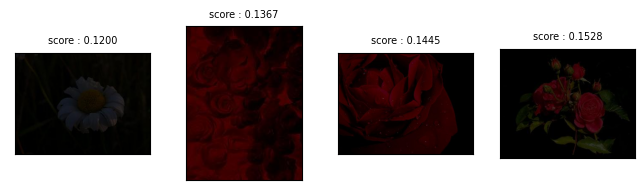

In [8]:
# Show how many issues with dataset
# Finding faults with train images.
from cleanvision.imagelab import Imagelab

# Specify path to folder containing the image files in your dataset
imagelab = Imagelab(data_path="darkened_images/")

issue_types = {"dark": {}}
imagelab.find_issues(issue_types=issue_types)

# Produce a report with only the specified issue_types
imagelab.report()


Number of darked images should be around the same amount specified in script, that would be 25% or around 700 images for us

### Create a new dir with dark images train/test split

In [9]:
from scripts import create_train_dataset_from_images as ctd

ctd.create_train_dataset_from_images('darkened_images', 'flowers_original_dark_dataset','train')
ctd.create_train_dataset_from_images('flowers/test', 'flowers_original_dark_dataset','test')

file_count = 0
for root, dirs, files in os.walk('flowers_original_dark_dataset/train'):
    file_count += len(files)

print(f"The total number of files in flowers_original_dark_dataset/train and its subdirectories is: {file_count}")

Moved and renamed 'darkened_images' to 'flowers_original_dark_dataset/train'
Moved and renamed 'flowers/test' to 'flowers_original_dark_dataset/test'
The total number of files in flowers_original_dark_dataset/train and its subdirectories is: 2934


## Setting up variables

In [10]:
PIPELINE_NAME = 'flower_pipeline'
PIPELINE_ROOT = os.path.join('pipelines', PIPELINE_NAME)
ORIGINAL_DARK_TF_RECORD_ROOT = 'flowers_original_dark_dataset-tfrecord'

ORIGINAL_DARK_DATA_ROOT = 'flowers_original_dark_dataset'


SERVING_MODEL_DIR = os.path.join('serving_model', PIPELINE_NAME)
METADATA_PATH = os.path.join('metadata', PIPELINE_NAME, 'flowers.db')

### Convert original dark images to tf.record files

In [11]:
from scripts import convert_img_to_tfrecord_script as citfs


train_data_dir = os.path.join(ORIGINAL_DARK_DATA_ROOT, 'train')
validation_dir = os.path.join(ORIGINAL_DARK_DATA_ROOT, 'test')

os.makedirs(ORIGINAL_DARK_TF_RECORD_ROOT + '/train', exist_ok=True)
os.makedirs(ORIGINAL_DARK_TF_RECORD_ROOT + '/test', exist_ok=True)

train_tfrecord = ORIGINAL_DARK_TF_RECORD_ROOT + '/train/train_data.tfrecords'
test_tfrecord = ORIGINAL_DARK_TF_RECORD_ROOT + '/test/test_data.tfrecords'


citfs.open_and_write_TFRercord(train_data_dir, validation_dir, train_tfrecord, test_tfrecord)

Train and test TFRecord files created.


2023-05-15 09:31:38.098834: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-05-15 09:31:38.099596: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-05-15 09:31:38.100096: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (de24ab82592a): /proc/driver/nvidia/version does not exist
2023-05-15 09:31:38.104163: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Checking if decoding tfrecord file works

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt

def _parse_function(example_proto):
    feature_description = {
        'label': tf.io.FixedLenFeature([], tf.int64),
        'image_raw': tf.io.FixedLenFeature([], tf.string),
    }
    parsed_features = tf.io.parse_single_example(example_proto, feature_description)
    return parsed_features

def display_first_matching_by_label(tfrecord_file, label_number):
    label_to_flower = {
        0: 'daisy',
        1: 'dandelion',
        2: 'roses',
        3: 'sunflowers',
        4: 'tulips'
    }
    
    raw_image_dataset = tf.data.TFRecordDataset(tfrecord_file)
    image_dataset = raw_image_dataset.map(_parse_function)

    for image_features in image_dataset:
        label = image_features['label']
        if label == label_number:
            encoded_image = image_features['image_raw'].numpy()
            decoded_image = tf.image.decode_jpeg(encoded_image, channels=3)
            plt.imshow(decoded_image)
            plt.title(f'Label: {label} {label_to_flower[label_number]}')
            plt.show()
            break

# Display the first image with the specified label (0 to 4) from the train TFRecord file
display_first_matching_by_label(train_tfrecord, 2)


### Model code

In [12]:
_trainer_module_file = 'flower_trainer.py'

In [14]:
%%writefile {_trainer_module_file}

import tensorflow as tf
from tfx import v1 as tfx
import matplotlib.pyplot as plt
import tensorflow_transform as tft
from tfx_bsl.tfxio import dataset_options
import os
import gzip
from typing import List
from tensorflow_metadata.proto.v0 import schema_pb2
from tfx import v1 as tfx
from tfx_bsl.public import tfxio
from tensorflow_transform.tf_metadata import schema_utils

_IMAGE_KEY = 'image_raw'
_LABEL_KEY = 'label'
IMG_HEIGHT = 180
IMG_WIDTH = 180
batch_size = 12

# TODO: Change this to what the actual train/test dir amount is, can be found with a print somewhere above
#_TRAIN_DATA_SIZE = 2934
_TRAIN_DATA_SIZE = 2203
_TEST_DATA_SIZE = 736


def _transformed_name(key):
  return key + '_xf'

# TFX Transform will call this function.
def preprocessing_fn(inputs):
  """tf.transform's callback function for preprocessing inputs.
  Args:
    inputs: map from feature keys to raw not-yet-transformed features.
  Returns:
    Map from string feature key to transformed feature operations.
  """
  outputs = {}
  print("Transformer preprocessing is running....")
  image_features = tf.map_fn(
      lambda x: tf.io.decode_jpeg(x[0], channels=3),
      inputs[_IMAGE_KEY],
      dtype=tf.uint8)
  
  image_features = tf.image.resize(image_features, [IMG_HEIGHT, IMG_WIDTH])
  image_features = tf.cast(image_features, tf.float32)
  # Normalize the image features
  # image_features = image_features / 255.0

  image_features = tf.keras.applications.mobilenet.preprocess_input(
     image_features)
  outputs[_transformed_name(_IMAGE_KEY)] = image_features
  outputs[_transformed_name(_LABEL_KEY)] = inputs[_LABEL_KEY]
  
  return outputs


# Define a function to parse the tfrecord dataset
def _parse_function(features, label):
   image = features[_transformed_name(_IMAGE_KEY)]
   return image, label

def _get_serve_image_fn(model):
  """Returns a function that feeds the input tensor into the model."""
  print("_get_serve_image_fn is running...\n\n\n")
  @tf.function
  def serve_image_fn(image_tensor):
      
    print("serve_image_fn is running...\n\n\n")
    """Returns the output to be used in the serving signature.
    Args:
      image_tensor: A tensor represeting input image. The image should have 3
        channels.
    Returns:
      The model's predicton on input image tensor
    """
    return model(image_tensor)

  return serve_image_fn

def _input_fn(file_pattern: List[str],
              data_accessor: tfx.components.DataAccessor,
              tf_transform_output: tft.TFTransformOutput,
              batch_size: int = 12) -> tf.data.Dataset:
  """Generates features and label for training.

  Args:
    file_pattern: List of paths or patterns of input tfrecord files.
    data_accessor: DataAccessor for converting input to RecordBatch.
    schema: schema of the input data.
    batch_size: representing the number of consecutive elements of returned
      dataset to combine in a single batch

  Returns:
    A dataset that contains (features, indices) tuple where features is a
      dictionary of Tensors, and indices is a single Tensor of label indices.
  """  
  dataset = data_accessor.tf_dataset_factory(
      file_pattern,
      dataset_options.TensorFlowDatasetOptions(
          batch_size=batch_size, label_key=_transformed_name(_LABEL_KEY)),
      tf_transform_output.transformed_metadata.schema)
  
  return dataset

# TFX Trainer will call this function.
def run_fn(fn_args: tfx.components.FnArgs):
    
    print("\n\n\n Trainer component is running ... \n\n\n")

    epochs = 4
    # attempt at making a different model architecture that should be smaller than the original
    
    """
    OLD MODEL
    model = tf.keras.Sequential([
      #tf.keras.layers.Rescaling(1./255),
      tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),

      tf.keras.layers.Conv2D(32, 3, activation='relu'),
      tf.keras.layers.MaxPooling2D(),
      tf.keras.layers.Conv2D(32, 3, activation='relu'),
      tf.keras.layers.MaxPooling2D(),
      tf.keras.layers.Conv2D(32, 3, activation='relu'),
      tf.keras.layers.MaxPooling2D(),
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(128, activation='relu'),
      tf.keras.layers.Dropout(0.5),
      tf.keras.layers.Dense(1, activation='sigmoid'),
      tf.keras.layers.Dense(5) # 5 for num of classes of flowers
    ])
    """
    model = tf.keras.Sequential([
      tf.keras.layers.Rescaling(1./255, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3), name=_transformed_name(_IMAGE_KEY)),
      tf.keras.layers.Conv2D(16, 3, padding='same', activation='relu'),
      tf.keras.layers.MaxPooling2D(),
      tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu'),
      tf.keras.layers.MaxPooling2D(),
      tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
      tf.keras.layers.MaxPooling2D(),
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(128, activation='relu'),
      tf.keras.layers.Dense(5)  # 5 for num of classes of flowers
    ])

 
    # Compile the model
    # OLD CODE
    #model.compile(optimizer='adam',
    #          loss=tf.keras.losses.BinaryCrossentropy(),
    #          metrics=['accuracy'])
    # NEW CODE
    model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
    
    # Print a summary of the model
    model.summary()

    tf_transform_output = tft.TFTransformOutput(fn_args.transform_output)
 
    train_ds = _input_fn(
      fn_args.train_files,
      fn_args.data_accessor,
      tf_transform_output,
      batch_size=batch_size)
    
    train_ds = train_ds.map(_parse_function)

    eval_ds = _input_fn(
      fn_args.eval_files,
      fn_args.data_accessor,
      tf_transform_output,
      batch_size=batch_size)
    
    eval_ds = eval_ds.map(_parse_function)

    steps_per_epoch = int(_TRAIN_DATA_SIZE / batch_size)
    validation_steps = int(_TEST_DATA_SIZE / batch_size)

    # Train our model
    history = model.fit(train_ds,
                        epochs=epochs,
                        validation_data=eval_ds, 
                        steps_per_epoch=steps_per_epoch, 
                        validation_steps=validation_steps)

    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(epochs)

    plt.figure(figsize=(8, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()


    # Prepare the TFLite model used for serving in MLKit
    signatures = {
        'serving_default':
            _get_serve_image_fn(model).get_concrete_function(
                tf.TensorSpec(
                    shape=[None, IMG_HEIGHT, IMG_WIDTH, 3],
                    dtype=tf.float32,
                    name=_transformed_name(_IMAGE_KEY)))
    }
    # The result of the training should be saved in `fn_args.serving_model_dir`
    # directory.
    model.save(fn_args.serving_model_dir, save_format='tf')

Overwriting flower_trainer.py


### Pipeline definition

In [15]:

### This pipeline hard codes the dataset path inside the pipeline instead of as a input when running orchestrator
import tensorflow_model_analysis as tfma

from tfx.proto import example_gen_pb2
from tfx.components import ImportExampleGen, Evaluator
from tfx import v1 as tfx
from tfx.dsl.components.common import resolver
from tfx.dsl.experimental import latest_blessed_model_resolver
from tfx.types import Channel
from tfx.types.standard_artifacts import Model, ModelBlessing
from tfx.proto import example_gen_pb2
from tfx.types.standard_artifacts import Model

import tensorflow_model_analysis as tfma

from tfx.dsl.input_resolution.strategies.latest_blessed_model_strategy import LatestBlessedModelStrategy

def _create_pipeline(pipeline_name: str, pipeline_root: str, 
                     tf_record_path: str, module_file: str, 
                     serving_model_dir: str, 
                     metadata_path: str,   accuracy_threshold: float = 0.15) -> tfx.dsl.Pipeline:
  print("Pipeline creation is running...\n\n\n")
 
  input_config = example_gen_pb2.Input(splits=[
      example_gen_pb2.Input.Split(name='train', pattern='train/*'),
      example_gen_pb2.Input.Split(name='eval', pattern='test/*')
  ])
#TODO: Move hardcoded input base into an external variable and send it into the pipeline
  # Brings data into the pipeline.
  example_gen = ImportExampleGen(
      input_base=tf_record_path, input_config=input_config)

  # Computes statistics over data for visualization and schema generation.
  statistics_gen = tfx.components.StatisticsGen(
      examples=example_gen.outputs['examples'])
  
  # Generates schema based on the generated statistics.
  schema_gen = tfx.components.SchemaGen(
      statistics=statistics_gen.outputs['statistics'], infer_feature_shape=True)

  #Performs anomaly detection based on statistics and data schema.
  example_validator = tfx.components.ExampleValidator(
      statistics=statistics_gen.outputs['statistics'],
      schema = schema_gen.outputs['schema']
  )

  # Performs transformations and feature engineering in training and serving.
  transform = tfx.components.Transform(
      examples=example_gen.outputs['examples'],
      schema=schema_gen.outputs['schema'],
      module_file=module_file)

  # Uses user-provided Python function that trains a model.
  trainer = tfx.components.Trainer(
      module_file=module_file,
      examples=transform.outputs['transformed_examples'],
      transform_graph=transform.outputs['transform_graph'],
      schema= schema_gen.outputs['schema'],
      )
  
  
  # Get the latest blessed model for model validation.
  model_resolver = resolver.Resolver(
      #strategy_class=latest_blessed_model_resolver.LatestBlessedModelResolver,
      strategy_class=LatestBlessedModelStrategy,
      model=Channel(type=Model),
      model_blessing=Channel(
          type=ModelBlessing)).with_id('latest_blessed_model_resolver')
  
  
  # Uses TFMA to compute evaluation statistics over features of a model and
  # perform quality validation of a candidate model (compare to a baseline).
  eval_config = tfma.EvalConfig(
      model_specs=[tfma.ModelSpec(label_key='label_xf')],
      slicing_specs=[tfma.SlicingSpec()],
      metrics_specs=[
          tfma.MetricsSpec(metrics=[
              tfma.MetricConfig(
                  class_name='SparseCategoricalAccuracy',
                  threshold=tfma.MetricThreshold(
                      value_threshold=tfma.GenericValueThreshold(
                          lower_bound={'value': accuracy_threshold}),
                      # Change threshold will be ignored if there is no
                      # baseline model resolved from MLMD (first run).
                      change_threshold=tfma.GenericChangeThreshold(
                          direction=tfma.MetricDirection.HIGHER_IS_BETTER,
                          absolute={'value': -1e-3})))
          ])
      ])

  # Uses TFMA to compute the evaluation statistics over features of a model.
  # We evaluate using the materialized examples that are output by Transform
  # because
  # 1. the decoding_jpeg function currently performed within Transform are not
  # compatible with TFLite.
  # 2. MLKit requires deserialized (float32) tensor image inputs
  # Note that for deployment, the same logic that is performed within Transform
  # must be reproduced client-side.
  evaluator = Evaluator(
      examples=transform.outputs['transformed_examples'],
      model=trainer.outputs['model'],
      baseline_model=model_resolver.outputs['model'],
      eval_config=eval_config)
  
  # Pushes the model to a filesystem destination.
  pusher = tfx.components.Pusher(
      model=trainer.outputs['model'],
      model_blessing=evaluator.outputs['blessing'], # Pass an evaluation result.
      push_destination=tfx.proto.PushDestination(
          filesystem=tfx.proto.PushDestination.Filesystem(
              base_directory=serving_model_dir)))
  
  # Following three components will be included in the pipeline.
  components = [
      example_gen,
      statistics_gen,
      schema_gen,
      example_validator,
      transform,
      trainer,
      model_resolver,
      evaluator,
      pusher,
  ]

  return tfx.dsl.Pipeline(
      pipeline_name=pipeline_name,
      pipeline_root=pipeline_root,
      metadata_connection_config=tfx.orchestration.metadata
      .sqlite_metadata_connection_config(metadata_path),
      components=components)

### Run Pipeline First Attempt With Dark Images

Pipeline creation is running...



running bdist_wheel
running build
running build_py
creating build
creating build/lib
copying penguin_utils.py -> build/lib
copying dogs_vs_cats_trainer.py -> build/lib
copying flower_trainer.py -> build/lib
copying remove_csv.py -> build/lib
installing to /tmp/tmpp36sgnad
running install
running install_lib


/usr/local/lib/python3.7/site-packages/setuptools/command/install.py:37: SetuptoolsDeprecationWarning: setup.py install is deprecated. Use build and pip and other standards-based tools.
  setuptools.SetuptoolsDeprecationWarning,


copying build/lib/penguin_utils.py -> /tmp/tmpp36sgnad
copying build/lib/dogs_vs_cats_trainer.py -> /tmp/tmpp36sgnad
copying build/lib/flower_trainer.py -> /tmp/tmpp36sgnad
copying build/lib/remove_csv.py -> /tmp/tmpp36sgnad
running install_egg_info
running egg_info
creating tfx_user_code_Transform.egg-info
writing tfx_user_code_Transform.egg-info/PKG-INFO
writing dependency_links to tfx_user_code_Transform.egg-info/dependency_links.txt
writing top-level names to tfx_user_code_Transform.egg-info/top_level.txt
writing manifest file 'tfx_user_code_Transform.egg-info/SOURCES.txt'
reading manifest file 'tfx_user_code_Transform.egg-info/SOURCES.txt'
writing manifest file 'tfx_user_code_Transform.egg-info/SOURCES.txt'
Copying tfx_user_code_Transform.egg-info to /tmp/tmpp36sgnad/tfx_user_code_Transform-0.0+6fbb78051926675528d4e305baf7a185916e630f192900af803ac5269325f407-py3.7.egg-info
running install_scripts
creating /tmp/tmpp36sgnad/tfx_user_code_Transform-0.0+6fbb78051926675528d4e305baf7a18

/usr/local/lib/python3.7/site-packages/setuptools/command/install.py:37: SetuptoolsDeprecationWarning: setup.py install is deprecated. Use build and pip and other standards-based tools.
  setuptools.SetuptoolsDeprecationWarning,


running egg_info
creating tfx_user_code_Trainer.egg-info
writing tfx_user_code_Trainer.egg-info/PKG-INFO
writing dependency_links to tfx_user_code_Trainer.egg-info/dependency_links.txt
writing top-level names to tfx_user_code_Trainer.egg-info/top_level.txt
writing manifest file 'tfx_user_code_Trainer.egg-info/SOURCES.txt'
reading manifest file 'tfx_user_code_Trainer.egg-info/SOURCES.txt'
writing manifest file 'tfx_user_code_Trainer.egg-info/SOURCES.txt'
Copying tfx_user_code_Trainer.egg-info to /tmp/tmpc5w9ufvr/tfx_user_code_Trainer-0.0+6fbb78051926675528d4e305baf7a185916e630f192900af803ac5269325f407-py3.7.egg-info
running install_scripts
creating /tmp/tmpc5w9ufvr/tfx_user_code_Trainer-0.0+6fbb78051926675528d4e305baf7a185916e630f192900af803ac5269325f407.dist-info/WHEEL
creating '/tmp/tmpf6rydyls/tfx_user_code_Trainer-0.0+6fbb78051926675528d4e305baf7a185916e630f192900af803ac5269325f407-py3-none-any.whl' and adding '/tmp/tmpc5w9ufvr' to it
adding 'dogs_vs_cats_trainer.py'
adding 'flower_

Processing ./pipelines/flower_pipeline/_wheels/tfx_user_code_Transform-0.0+6fbb78051926675528d4e305baf7a185916e630f192900af803ac5269325f407-py3-none-any.whl


You should consider upgrading via the '/usr/local/bin/python -m pip install --upgrade pip' command.


Processing ./pipelines/flower_pipeline/_wheels/tfx_user_code_Transform-0.0+6fbb78051926675528d4e305baf7a185916e630f192900af803ac5269325f407-py3-none-any.whl


You should consider upgrading via the '/usr/local/bin/python -m pip install --upgrade pip' command.


Processing ./pipelines/flower_pipeline/_wheels/tfx_user_code_Transform-0.0+6fbb78051926675528d4e305baf7a185916e630f192900af803ac5269325f407-py3-none-any.whl
Transformer preprocessing is running....
Instructions for updating:
Use fn_output_signature instead


You should consider upgrading via the '/usr/local/bin/python -m pip install --upgrade pip' command.
Instructions for updating:
Use fn_output_signature instead


Instructions for updating:
Use ref() instead.


Instructions for updating:
Use ref() instead.


Transformer preprocessing is running....
Transformer preprocessing is running....


Transformer preprocessing is running....
Transformer preprocessing is running....
Transformer preprocessing is running....
Transformer preprocessing is running....
Transformer preprocessing is running....
INFO:tensorflow:Assets written to: pipelines/flower_pipeline/Transform/transform_graph/6/.temp_path/tftransform_tmp/0c3f38dc884040dd8878b0b1641662e4/assets


INFO:tensorflow:Assets written to: pipelines/flower_pipeline/Transform/transform_graph/6/.temp_path/tftransform_tmp/0c3f38dc884040dd8878b0b1641662e4/assets


Transformer preprocessing is running....
INFO:tensorflow:struct2tensor is not available.


INFO:tensorflow:struct2tensor is not available.


INFO:tensorflow:tensorflow_decision_forests is not available.


INFO:tensorflow:tensorflow_decision_forests is not available.


INFO:tensorflow:tensorflow_text is not available.


INFO:tensorflow:tensorflow_text is not available.


INFO:tensorflow:struct2tensor is not available.


INFO:tensorflow:struct2tensor is not available.


INFO:tensorflow:tensorflow_decision_forests is not available.


INFO:tensorflow:tensorflow_decision_forests is not available.


INFO:tensorflow:tensorflow_text is not available.


INFO:tensorflow:tensorflow_text is not available.


Processing ./pipelines/flower_pipeline/_wheels/tfx_user_code_Trainer-0.0+6fbb78051926675528d4e305baf7a185916e630f192900af803ac5269325f407-py3-none-any.whl



 Trainer component is running ... 





You should consider upgrading via the '/usr/local/bin/python -m pip install --upgrade pip' command.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 image_raw_xf (Rescaling)    (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


Epoch 1/4


2023-05-15 09:37:51.355368: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 5260 of 10000
2023-05-15 09:37:58.126523: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


183/183 [==============================] - 52s 179ms/step - loss: 1.6070 - accuracy: 0.2341 - val_loss: 1.6025 - val_accuracy: 0.2445
Epoch 2/4
183/183 [==============================] - 42s 231ms/step - loss: 1.6006 - accuracy: 0.2468 - val_loss: 1.6005 - val_accuracy: 0.2459
Epoch 3/4
183/183 [==============================] - 43s 236ms/step - loss: 1.6031 - accuracy: 0.2409 - val_loss: 1.5998 - val_accuracy: 0.2459
Epoch 4/4
183/183 [==============================] - 34s 189ms/step - loss: 1.5989 - accuracy: 0.2505 - val_loss: 1.6001 - val_accuracy: 0.2445


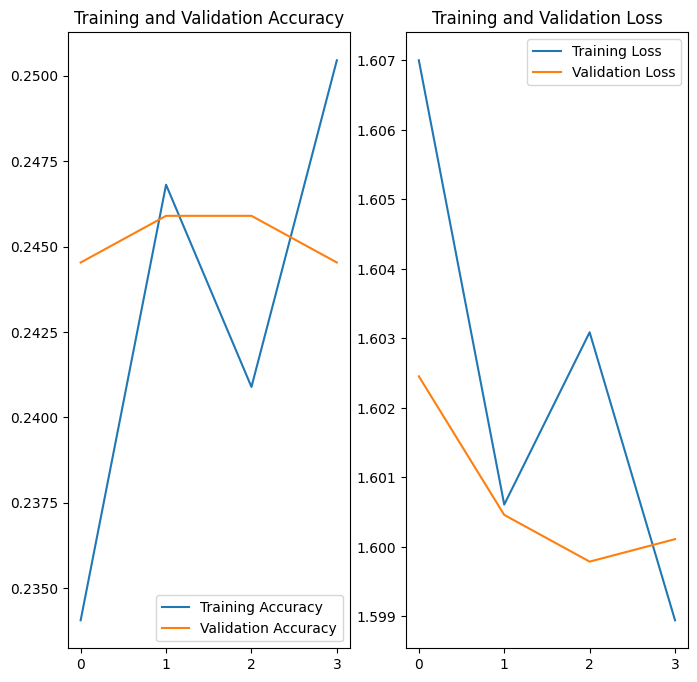

_get_serve_image_fn is running...



serve_image_fn is running...





INFO:tensorflow:Assets written to: pipelines/flower_pipeline/Trainer/model/7/Format-Serving/assets


INFO:tensorflow:Assets written to: pipelines/flower_pipeline/Trainer/model/7/Format-Serving/assets


Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`


Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`


In [17]:
tfx.orchestration.LocalDagRunner().run(
  _create_pipeline(
      pipeline_name=PIPELINE_NAME,
      pipeline_root=PIPELINE_ROOT,
      tf_record_path=ORIGINAL_DARK_TF_RECORD_ROOT,
      module_file=_trainer_module_file,
      serving_model_dir=SERVING_MODEL_DIR,
      metadata_path=METADATA_PATH))

### Clean dataset and run cleanlab to show improved dataset

Reading images from /workspaces/tfx_test_case/flowers_original_dark_dataset/train
Checking for dark images ...


100%|██████████| 2934/2934 [00:07<00:00, 366.90it/s]


Issue checks completed. To see a detailed report of issues found, use imagelab.report().
Issues found in order of severity in the dataset

|    | issue_type   |   num_images |
|---:|:-------------|-------------:|
|  0 | dark         |          731 | 


Top 4 examples with dark issue in the dataset.


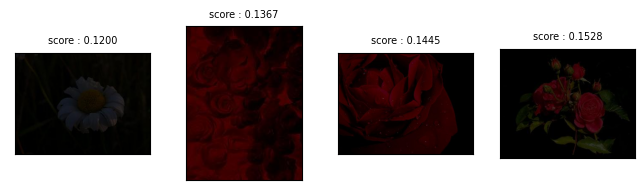

This list of image paths containts:  731 images


In [23]:
### Finding the dark images

# Specify path to folder containing the image files in your dataset
imagelab = Imagelab(data_path="flowers_original_dark_dataset/train/")

issue_types = {"dark": {}}
imagelab.find_issues(issue_types=issue_types)

# Produce a report with only the specified issue_types
imagelab.report()


In [35]:
# Run the brighten images script in order to 
%run 'scripts/brighten_image_script.py'

Processing completed. Darkened images have been saved to the 'brightened_images' directory.


Reading images from /workspaces/tfx_test_case/brightened_images
Checking for dark images ...


100%|██████████| 2934/2934 [00:07<00:00, 389.51it/s]


Issue checks completed. To see a detailed report of issues found, use imagelab.report().
Issues found in order of severity in the dataset

|    | issue_type   |   num_images |
|---:|:-------------|-------------:|
|  0 | dark         |           18 | 


Top 4 examples with dark issue in the dataset.


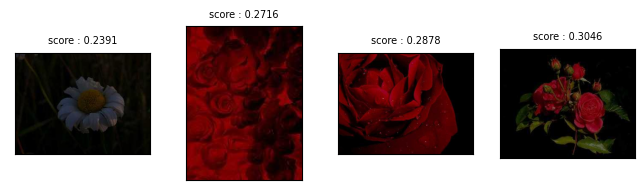

In [36]:
### Running again to show improvement in # of dark images

# Specify path to folder containing the image files in your dataset
imagelab = Imagelab(data_path="brightened_images")

issue_types = {"dark": {}}
imagelab.find_issues(issue_types=issue_types)

# Produce a report with only the specified issue_types
imagelab.report()

### Create a dataset directory with the same test set as the previous dataset

In [37]:
from scripts import create_train_dataset_from_images as ctd

ctd.create_train_dataset_from_images('brightened_images', 'flowers_improved_dataset','train')
ctd.create_train_dataset_from_images('flowers/test', 'flowers_improved_dataset','test')

file_count = 0
for root, dirs, files in os.walk('flowers_improved_dataset/train'):
    file_count += len(files)

print(f"The total number of files in flowers_improved_dataset/train and its subdirectories is: {file_count}")

Moved and renamed 'brightened_images' to 'flowers_improved_dataset/train'
Moved and renamed 'flowers/test' to 'flowers_improved_dataset/test'
The total number of files in flowers_improved_dataset/train and its subdirectories is: 2934


### Creating TFRecord files from improved dataset

In [39]:
from scripts import convert_img_to_tfrecord_script as citfs

IMPROVED_TF_RECORD_ROOT = 'flowers_improved_dataset-tfrecord'

IMPROVED_DARK_DATA_ROOT = 'flowers_improved_dataset'


train_data_dir = os.path.join(IMPROVED_DARK_DATA_ROOT, 'train')
validation_dir = os.path.join(IMPROVED_DARK_DATA_ROOT, 'test')

os.makedirs(IMPROVED_TF_RECORD_ROOT + '/train', exist_ok=True)
os.makedirs(IMPROVED_TF_RECORD_ROOT + '/test', exist_ok=True)

train_tfrecord = IMPROVED_TF_RECORD_ROOT + '/train/train_data.tfrecords'
test_tfrecord = IMPROVED_TF_RECORD_ROOT + '/test/test_data.tfrecords'


citfs.open_and_write_TFRercord(train_data_dir, validation_dir, train_tfrecord, test_tfrecord)

### Second pipeline run with improved dataset

Pipeline creation is running...



running bdist_wheel
running build
running build_py
creating build
creating build/lib
copying penguin_utils.py -> build/lib
copying dogs_vs_cats_trainer.py -> build/lib
copying flower_trainer.py -> build/lib
copying remove_csv.py -> build/lib
installing to /tmp/tmpzd77z1k0
running install
running install_lib
copying build/lib/penguin_utils.py -> /tmp/tmpzd77z1k0
copying build/lib/dogs_vs_cats_trainer.py -> /tmp/tmpzd77z1k0
copying build/lib/flower_trainer.py -> /tmp/tmpzd77z1k0
copying build/lib/remove_csv.py -> /tmp/tmpzd77z1k0
running install_egg_info


/usr/local/lib/python3.7/site-packages/setuptools/command/install.py:37: SetuptoolsDeprecationWarning: setup.py install is deprecated. Use build and pip and other standards-based tools.
  setuptools.SetuptoolsDeprecationWarning,


running egg_info
creating tfx_user_code_Transform.egg-info
writing tfx_user_code_Transform.egg-info/PKG-INFO
writing dependency_links to tfx_user_code_Transform.egg-info/dependency_links.txt
writing top-level names to tfx_user_code_Transform.egg-info/top_level.txt
writing manifest file 'tfx_user_code_Transform.egg-info/SOURCES.txt'
reading manifest file 'tfx_user_code_Transform.egg-info/SOURCES.txt'
writing manifest file 'tfx_user_code_Transform.egg-info/SOURCES.txt'
Copying tfx_user_code_Transform.egg-info to /tmp/tmpzd77z1k0/tfx_user_code_Transform-0.0+6fbb78051926675528d4e305baf7a185916e630f192900af803ac5269325f407-py3.7.egg-info
running install_scripts
creating /tmp/tmpzd77z1k0/tfx_user_code_Transform-0.0+6fbb78051926675528d4e305baf7a185916e630f192900af803ac5269325f407.dist-info/WHEEL
creating '/tmp/tmp1fnamqkc/tfx_user_code_Transform-0.0+6fbb78051926675528d4e305baf7a185916e630f192900af803ac5269325f407-py3-none-any.whl' and adding '/tmp/tmpzd77z1k0' to it
adding 'dogs_vs_cats_train

/usr/local/lib/python3.7/site-packages/setuptools/command/install.py:37: SetuptoolsDeprecationWarning: setup.py install is deprecated. Use build and pip and other standards-based tools.
  setuptools.SetuptoolsDeprecationWarning,


running egg_info
creating tfx_user_code_Trainer.egg-info
writing tfx_user_code_Trainer.egg-info/PKG-INFO
writing dependency_links to tfx_user_code_Trainer.egg-info/dependency_links.txt
writing top-level names to tfx_user_code_Trainer.egg-info/top_level.txt
writing manifest file 'tfx_user_code_Trainer.egg-info/SOURCES.txt'
reading manifest file 'tfx_user_code_Trainer.egg-info/SOURCES.txt'
writing manifest file 'tfx_user_code_Trainer.egg-info/SOURCES.txt'
Copying tfx_user_code_Trainer.egg-info to /tmp/tmp17denlqq/tfx_user_code_Trainer-0.0+6fbb78051926675528d4e305baf7a185916e630f192900af803ac5269325f407-py3.7.egg-info
running install_scripts
creating /tmp/tmp17denlqq/tfx_user_code_Trainer-0.0+6fbb78051926675528d4e305baf7a185916e630f192900af803ac5269325f407.dist-info/WHEEL
creating '/tmp/tmpnv5_gfa5/tfx_user_code_Trainer-0.0+6fbb78051926675528d4e305baf7a185916e630f192900af803ac5269325f407-py3-none-any.whl' and adding '/tmp/tmp17denlqq' to it
adding 'dogs_vs_cats_trainer.py'
adding 'flower_

Processing ./pipelines/flower_pipeline/_wheels/tfx_user_code_Transform-0.0+6fbb78051926675528d4e305baf7a185916e630f192900af803ac5269325f407-py3-none-any.whl


You should consider upgrading via the '/usr/local/bin/python -m pip install --upgrade pip' command.


Processing ./pipelines/flower_pipeline/_wheels/tfx_user_code_Transform-0.0+6fbb78051926675528d4e305baf7a185916e630f192900af803ac5269325f407-py3-none-any.whl


You should consider upgrading via the '/usr/local/bin/python -m pip install --upgrade pip' command.


Processing ./pipelines/flower_pipeline/_wheels/tfx_user_code_Transform-0.0+6fbb78051926675528d4e305baf7a185916e630f192900af803ac5269325f407-py3-none-any.whl
Transformer preprocessing is running....


You should consider upgrading via the '/usr/local/bin/python -m pip install --upgrade pip' command.


Transformer preprocessing is running....
Transformer preprocessing is running....


Transformer preprocessing is running....
Transformer preprocessing is running....
Transformer preprocessing is running....
Transformer preprocessing is running....
Transformer preprocessing is running....
INFO:tensorflow:Assets written to: pipelines/flower_pipeline/Transform/transform_graph/15/.temp_path/tftransform_tmp/b2001effb0a94fea80b16c38ec278290/assets


INFO:tensorflow:Assets written to: pipelines/flower_pipeline/Transform/transform_graph/15/.temp_path/tftransform_tmp/b2001effb0a94fea80b16c38ec278290/assets


Transformer preprocessing is running....
INFO:tensorflow:struct2tensor is not available.


INFO:tensorflow:struct2tensor is not available.


INFO:tensorflow:tensorflow_decision_forests is not available.


INFO:tensorflow:tensorflow_decision_forests is not available.


INFO:tensorflow:tensorflow_text is not available.


INFO:tensorflow:tensorflow_text is not available.


INFO:tensorflow:struct2tensor is not available.


INFO:tensorflow:struct2tensor is not available.


INFO:tensorflow:tensorflow_decision_forests is not available.


INFO:tensorflow:tensorflow_decision_forests is not available.


INFO:tensorflow:tensorflow_text is not available.


INFO:tensorflow:tensorflow_text is not available.


Processing ./pipelines/flower_pipeline/_wheels/tfx_user_code_Trainer-0.0+6fbb78051926675528d4e305baf7a185916e630f192900af803ac5269325f407-py3-none-any.whl


You should consider upgrading via the '/usr/local/bin/python -m pip install --upgrade pip' command.





 Trainer component is running ... 



Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 image_raw_xf (Rescaling)    (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Co

2023-05-15 10:15:53.852249: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 4694 of 10000
2023-05-15 10:16:02.434278: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


183/183 [==============================] - 57s 199ms/step - loss: 1.6056 - accuracy: 0.2300 - val_loss: 1.6016 - val_accuracy: 0.2445
Epoch 2/4
183/183 [==============================] - 42s 231ms/step - loss: 1.6000 - accuracy: 0.2473 - val_loss: 1.6004 - val_accuracy: 0.2445
Epoch 3/4
183/183 [==============================] - ETA: 0s - loss: 1.6042 - accuracy: 0.2345

2023-05-15 10:18:03.998274: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 1807 of 10000
2023-05-15 10:18:06.582716: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


183/183 [==============================] - 52s 283ms/step - loss: 1.6042 - accuracy: 0.2345 - val_loss: 1.6008 - val_accuracy: 0.2445
Epoch 4/4
183/183 [==============================] - ETA: 0s - loss: 1.6004 - accuracy: 0.2509

2023-05-15 10:18:49.282728: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 8599 of 10000
2023-05-15 10:18:50.408713: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


183/183 [==============================] - 39s 215ms/step - loss: 1.6004 - accuracy: 0.2509 - val_loss: 1.6016 - val_accuracy: 0.2445


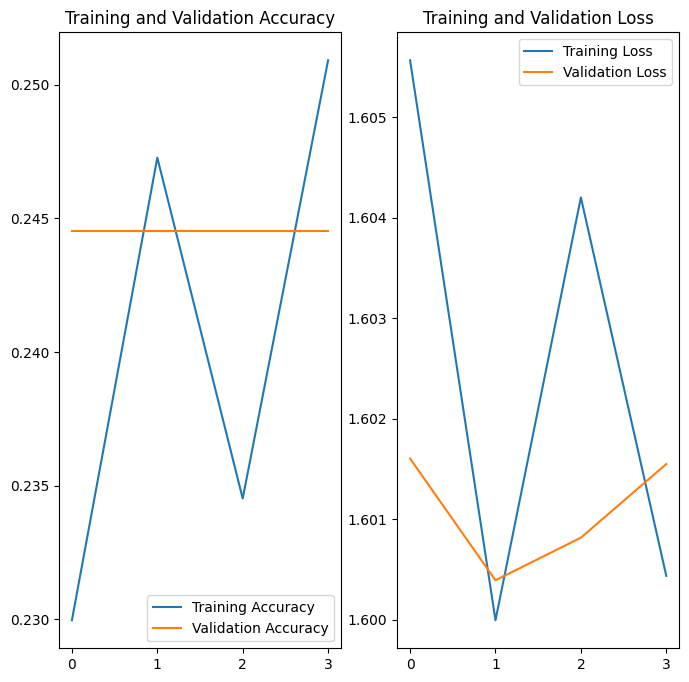

_get_serve_image_fn is running...



serve_image_fn is running...





INFO:tensorflow:Assets written to: pipelines/flower_pipeline/Trainer/model/16/Format-Serving/assets


INFO:tensorflow:Assets written to: pipelines/flower_pipeline/Trainer/model/16/Format-Serving/assets


In [40]:
tfx.orchestration.LocalDagRunner().run(
  _create_pipeline(
      pipeline_name=PIPELINE_NAME,
      pipeline_root=PIPELINE_ROOT,
      tf_record_path='flowers_improved_dataset-tfrecord',
      module_file=_trainer_module_file,
      serving_model_dir=SERVING_MODEL_DIR,
      metadata_path=METADATA_PATH))

### Getting Evaluator component and ouputting statistics

In [103]:
from ml_metadata import metadata_store
from ml_metadata.proto import metadata_store_pb2
import ml_metadata as mlmd
from ml_metadata.metadata_store import metadata_store
from ml_metadata.proto import metadata_store_pb2
from tfx.types.channel_utils import external_project_artifact_query


connection_config = tfx.orchestration.metadata.sqlite_metadata_connection_config(METADATA_PATH)
store = mlmd.MetadataStore(connection_config)

store.get_artifact_types()




[id: 15
 name: "Examples"
 properties {
   key: "span"
   value: INT
 }
 properties {
   key: "split_names"
   value: STRING
 }
 properties {
   key: "version"
   value: INT
 }
 base_type: DATASET,
 id: 18
 name: "ExampleStatistics"
 properties {
   key: "span"
   value: INT
 }
 properties {
   key: "split_names"
   value: STRING
 }
 base_type: STATISTICS,
 id: 20
 name: "Schema",
 id: 22
 name: "ExampleAnomalies"
 properties {
   key: "span"
   value: INT
 }
 properties {
   key: "split_names"
   value: STRING
 },
 id: 24
 name: "TransformCache",
 id: 25
 name: "TransformGraph",
 id: 27
 name: "ModelRun",
 id: 28
 name: "Model"
 base_type: MODEL,
 id: 30
 name: "ModelBlessing",
 id: 31
 name: "ModelEvaluation",
 id: 33
 name: "PushedModel"
 base_type: MODEL]

### Result querying

In [ ]:
# List files in created model directory.
!find {SERVING_MODEL_DIR}